# Reflect Tables into SQLAlchemy ORM

In [131]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [132]:
import numpy as np
import pandas as pd

In [133]:
import datetime as dt
from dateutil.relativedelta import relativedelta

In [134]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [135]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [136]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [137]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [138]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [139]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [140]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [141]:
AllMeasurementData = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.date > "2016-08-31").\
                                order_by(Measurement.date.desc()).limit(10).all()

In [142]:
for data in AllMeasurementData:
     print(data)
                                   
                        

(2724, 'USC00519397', '2017-08-23', 0.0, 81.0)
(7635, 'USC00514830', '2017-08-23', 0.0, 82.0)
(12187, 'USC00519523', '2017-08-23', 0.08, 82.0)
(19550, 'USC00516128', '2017-08-23', 0.45, 76.0)
(2723, 'USC00519397', '2017-08-22', 0.0, 82.0)
(12186, 'USC00519523', '2017-08-22', 0.0, 82.0)
(19549, 'USC00516128', '2017-08-22', 0.5, 76.0)
(2722, 'USC00519397', '2017-08-21', 0.0, 81.0)
(7634, 'USC00514830', '2017-08-21', 0.02, 79.0)
(12185, 'USC00519523', '2017-08-21', None, 82.0)


Precipitation Anaylsis

In [143]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(Measurement.date)).all()
last_date = last_date[0][0]
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d').date()
year_before_date = ((last_date - relativedelta(years = 1)).strftime('%Y-%m-%d'))

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_before_date).order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data, columns = ["date", "precipitation"])

# Sort the dataframe by date
df.sort_values(by = ["date"], ascending=True, inplace=True)
precipitation_df = pd.DataFrame(df)
precipitation_df

,date,precipitation
2229,2016-08-23,0.70
2223,2016-08-23,0.00
2224,2016-08-23,0.15
2228,2016-08-23,1.79
2226,2016-08-23,NaN
...,...,...
4,2017-08-22,0.00
3,2017-08-23,0.45
2,2017-08-23,0.08
1,2017-08-23,0.00


In [144]:
precipitation_df.set_index(["date"])
precipitation_df.head

<bound method NDFrame.head of             date  precipitation
2229  2016-08-23           0.70
2223  2016-08-23           0.00
2224  2016-08-23           0.15
2228  2016-08-23           1.79
2226  2016-08-23            NaN
...          ...            ...
4     2017-08-22           0.00
3     2017-08-23           0.45
2     2017-08-23           0.08
1     2017-08-23           0.00
0     2017-08-23           0.00

[2230 rows x 2 columns]>

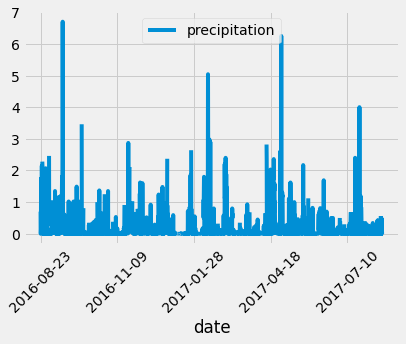

<Figure size 432x288 with 0 Axes>

In [155]:

# Use Pandas Plotting with Matplotlib to plot the data
chart = precipitation_df.plot(x = "date", y = "precipitation")
plt.xticks(rotation=45, horizontalalignment="center")
chart.legend(loc='upper center')
plt.show()
plt.tight_layout()

In [165]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe().round(2)

,precipitation
count,2021.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [166]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [171]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stations = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [179]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
all_observations = session.query(Measurement.station,func.min(Measurement.tobs)), func.max(Measurement.tobs, func.avg(Measurement.tobs)). \
filter(Measurement.station == stations[0])

all_observations

(<sqlalchemy.orm.query.Query at 0x7fb158645ef0>,
 <sqlalchemy.sql.elements.FunctionFilter object at 0x7fb158645668>)

In [181]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#5 Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

active_stations_val = stations[0] 
active_stations_val

active_stations_temps= session.query(Measurement.tobs).\
                        filter(Measurement.date >= "2016-08-23").\
                       filter(Measurement.station == "USC00519281").all()
active_stations_temps
len(active_stations_temps)

all_temps= [z[0] for z in active_stations_temps]
all_temps

[77.0,
 77.0,
 80.0,
 80.0,
 75.0,
 73.0,
 78.0,
 77.0,
 78.0,
 80.0,
 80.0,
 78.0,
 78.0,
 78.0,
 73.0,
 74.0,
 80.0,
 79.0,
 77.0,
 80.0,
 76.0,
 79.0,
 75.0,
 79.0,
 78.0,
 79.0,
 78.0,
 78.0,
 76.0,
 74.0,
 77.0,
 78.0,
 79.0,
 79.0,
 77.0,
 80.0,
 78.0,
 78.0,
 78.0,
 77.0,
 79.0,
 79.0,
 79.0,
 79.0,
 75.0,
 76.0,
 73.0,
 72.0,
 71.0,
 77.0,
 79.0,
 78.0,
 79.0,
 77.0,
 79.0,
 77.0,
 78.0,
 78.0,
 78.0,
 78.0,
 77.0,
 74.0,
 75.0,
 76.0,
 73.0,
 76.0,
 74.0,
 77.0,
 76.0,
 76.0,
 74.0,
 75.0,
 75.0,
 75.0,
 75.0,
 71.0,
 63.0,
 70.0,
 68.0,
 67.0,
 77.0,
 74.0,
 77.0,
 76.0,
 76.0,
 75.0,
 76.0,
 75.0,
 73.0,
 75.0,
 73.0,
 75.0,
 74.0,
 75.0,
 74.0,
 75.0,
 73.0,
 75.0,
 73.0,
 73.0,
 74.0,
 70.0,
 72.0,
 70.0,
 67.0,
 67.0,
 69.0,
 70.0,
 68.0,
 69.0,
 69.0,
 66.0,
 65.0,
 68.0,
 62.0,
 75.0,
 70.0,
 69.0,
 76.0,
 76.0,
 74.0,
 73.0,
 71.0,
 74.0,
 74.0,
 72.0,
 71.0,
 72.0,
 74.0,
 69.0,
 67.0,
 72.0,
 70.0,
 64.0,
 63.0,
 63.0,
 62.0,
 70.0,
 70.0,
 62.0,
 62.0,
 63.0,
 65.0,

<Figure size 432x288 with 0 Axes>

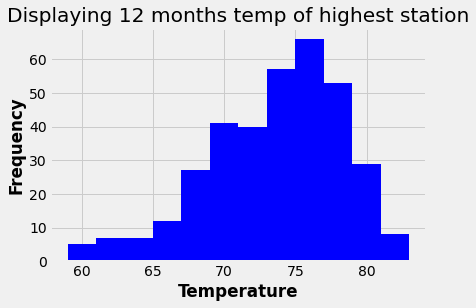

<Figure size 432x288 with 0 Axes>

In [182]:
#plt.hist(all_temps, bins= 12)
plt.hist(all_temps, bins=12, color="blue")
plt.title("Displaying 12 months temp of highest station")
labels = ['tobs']
plt.ylabel('Frequency', weight='bold')
plt.xlabel('Temperature', weight='bold')
plt.figure(2)